In [1]:
import cv2
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern, hog
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [ ]:
df = pd.read_csv("./data/samsung/Metadata_NO2_samsung.csv")
df.head()

,STT,ID_img,ppm,note
0,1,0sv9g_ngochanpham274@gmail.com_2024-11-29 11_2...,0.250,002_samsung test_10.876833_106.6782313.jpg
1,2,15Ukv_ngochanpham274@gmail.com_2024-11-29 11_3...,0.900,002_samsung test_10.876833_106.6782313.jpg
2,3,2d7cQ_ngochanpham274@gmail.com_2024-11-29 11_3...,0.600,002_samsung test_10.876833_106.6782313.jpg
3,4,2En27_ngochanpham274@gmail.com_2024-11-29 11_5...,9.000,001_samsung test_10.8768544_106.6782314.jpg
4,5,314Lk_ngochanpham274@gmail.com_2024-11-29 11_0...,0.025,002_samsung test_10.8768398_106.6782302.jpg


In [3]:
# Set the image_id as the index in data_pd
df.set_index('ID_img', inplace=True)

In [ ]:
# Path to the directory containing data
data_dir = './data/samsung/samsung/NO2/middle'
image_size = (256, 256)  # Image size (optional)

# Read all images in the directory
def load_images(data_dir, image_size):
    images = []
    labels = []
    for img_name in os.listdir(data_dir):
        img_path = os.path.join(data_dir, img_name)
        if os.path.isfile(img_path):  # Ensure this is a file
            try:
                image = cv2.imread(img_path)
                if image is None:  # Check if the file is a valid image
                    print(f"File {img_path} is not a valid image.")
                    continue
                
                image = cv2.resize(image, image_size)
                
                # Get label from DataFrame df_NH3
                label = df.loc[img_name, 'ppm']
                
                images.append(image)
                labels.append(label)
            except Exception as e:
                print(f"Error reading image {img_path}: {e}")

    return np.array(images), np.array(labels)

# Load dataset
images, labels = load_images(data_dir, image_size)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.4, random_state=42)

In [ ]:
# Convert color space: RGB, HSV, L*a*b*
def extract_color_features(image):
    rgb_mean = np.mean(image, axis=(0,1))  # Compute the mean for each RGB channel
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv_mean = np.mean(hsv_image, axis=(0,1))  # Compute the mean in the HSV color space
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    lab_mean = np.mean(lab_image, axis=(0,1))  # Compute the mean in the L*a*b* color space
    
    return np.concatenate([rgb_mean, hsv_mean, lab_mean])

# Apply color feature extraction to all images
X_train_features = np.array([extract_color_features(img) for img in X_train])
X_test_features = np.array([extract_color_features(img) for img in X_test])

In [ ]:
# Extract LBP and HOG
def extract_texture_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # LBP (Local Binary Pattern)
    lbp = local_binary_pattern(gray_image, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp, bins=np.arange(0, 11), range=(0, 10), density=True)
    
    # HOG (Histogram of Oriented Gradients)
    hog_features, _ = hog(gray_image, orientations=9, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), visualize=True)
    
    return np.concatenate([lbp_hist, hog_features])

# Apply texture feature extraction
X_train_texture = np.array([extract_texture_features(img) for img in X_train])
X_test_texture = np.array([extract_texture_features(img) for img in X_test])

In [ ]:
# Combine color and texture features
X_train_combined = np.concatenate([X_train_features, X_train_texture], axis=1)
X_test_combined = np.concatenate([X_test_features, X_test_texture], axis=1)

In [8]:
print(X_train_combined.shape)
print(X_test_combined.shape)

(51, 34615)
(34, 34615)


In [ ]:
# Linear Regression
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

param_grid_lr = {
    'lr__fit_intercept': [True, False],
}

In [ ]:
# SVM (Support Vector Regressor)
pipeline_svr = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

param_grid_svr = {
    'svr__kernel': ['linear', 'rbf'],
    'svr__C': [0.1, 1, 10],
    'svr__gamma': ['scale', 'auto']
}

In [ ]:
# Random Forest Regressor
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor())
])

param_grid_rf = {
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [10, 20],
    'rf__min_samples_split': [5, 10]
}

In [ ]:
# GridSearchCV for each model
grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=5, scoring='neg_mean_squared_error')
grid_search_svr = GridSearchCV(pipeline_svr, param_grid_svr, cv=5, scoring='neg_mean_squared_error')
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error')

# Train each model
print("Training Linear Regression...")
grid_search_lr.fit(X_train_combined, y_train)

print("Training SVR...")
grid_search_svr.fit(X_train_combined, y_train)

print("Training Random Forest Regressor...")
grid_search_rf.fit(X_train_combined, y_train)

# Print the best results for each model
print("Best parameters for Linear Regression:", grid_search_lr.best_params_)
print("Best parameters for SVR:", grid_search_svr.best_params_)
print("Best parameters for Random Forest Regressor:", grid_search_rf.best_params_)

Training Linear Regression...
Training SVR...
Training Random Forest Regressor...
Best parameters for Linear Regression: {'lr__fit_intercept': True}
Best parameters for SVR: {'svr__C': 0.1, 'svr__gamma': 'scale', 'svr__kernel': 'linear'}
Best parameters for Random Forest Regressor: {'rf__max_depth': 20, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}


In [ ]:
# Save the best model and weights for Linear Regression
joblib.dump(grid_search_lr.best_estimator_, 'best_linear_regression_model.pkl')
joblib.dump(grid_search_lr.best_params_, 'best_linear_regression_params.pkl')

# Save the best model and weights for SVR
joblib.dump(grid_search_svr.best_estimator_, 'best_svr_model.pkl')
joblib.dump(grid_search_svr.best_params_, 'best_svr_params.pkl')

# Save the best model and weights for Random Forest Regressor
joblib.dump(grid_search_rf.best_estimator_, 'best_random_forest_model.pkl')
joblib.dump(grid_search_rf.best_params_, 'best_random_forest_params.pkl')

['best_random_forest_params.pkl']

In [ ]:
# Evaluate the model on the test set
y_pred_lr = grid_search_lr.predict(X_test_combined)
y_pred_svr = grid_search_svr.predict(X_test_combined)
y_pred_rf = grid_search_rf.predict(X_test_combined)

# Linear Regression, SVR, Random Forest Regressor (Mean Squared Error)
mse_lr = mean_squared_error(y_test, y_pred_lr)
mse_svr = mean_squared_error(y_test, y_pred_svr)
mse_rf = mean_squared_error(y_test, y_pred_rf)

# Compute R² score for Linear Regression, SVR, and Random Forest Regressor
r2_lr = r2_score(y_test, y_pred_lr)
r2_svr = r2_score(y_test, y_pred_svr)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Linear Regression MSE: {mse_lr}, LR R2: {r2_lr}\n")
print(f"SVR MSE: {mse_svr}, SVR R2: {r2_svr}\n")
print(f"Random Forest Regressor MSE: {mse_rf}, RF R2: {r2_rf}\n")

Linear Regression MSE: 3.178817267068811, LR R2: 0.6401057503147098

SVR MSE: 3.2353081413868394, SVR R2: 0.6337100568480325

Random Forest Regressor MSE: 2.6799713449317544, RF R2: 0.6965832901582092



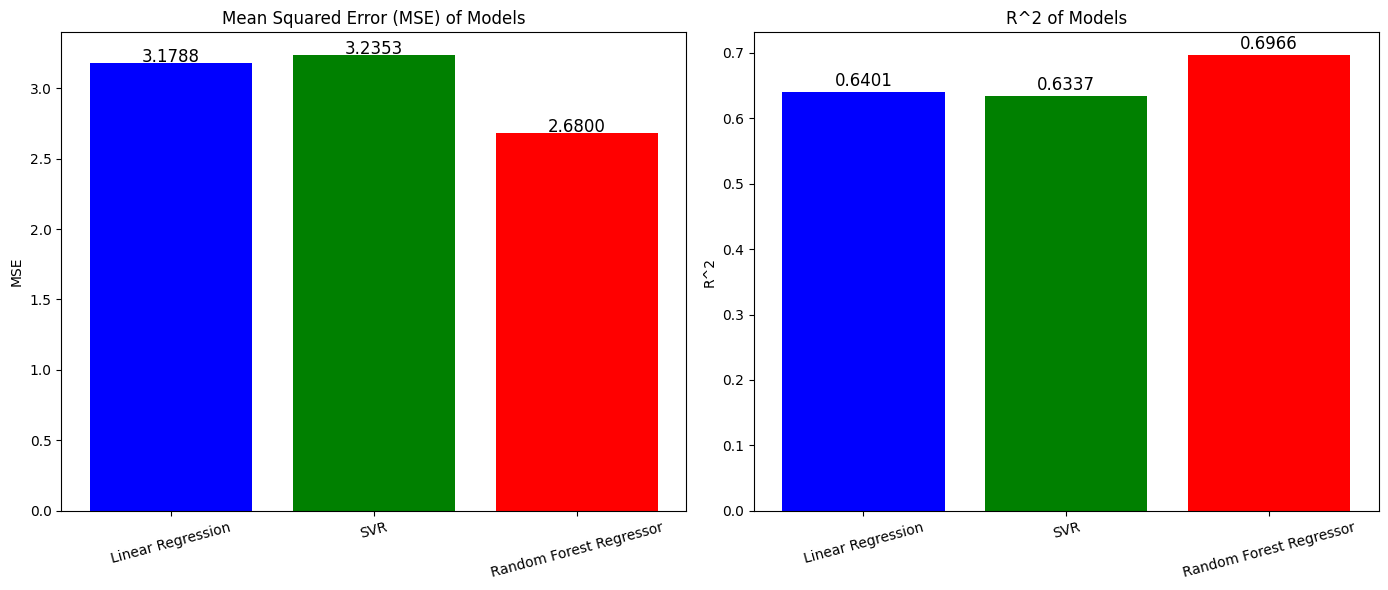

In [ ]:
# MSE and R^2 data
models = ['Linear Regression', 'SVR', 'Random Forest Regressor']
mse_values = [mse_lr, mse_svr, mse_rf]
r2_values = [r2_lr, r2_svr, r2_rf]

# Create MSE plot
plt.figure(figsize=(14, 6))

# MSE
plt.subplot(1, 2, 1)
plt.bar(models, mse_values, color=['blue', 'green', 'red'])
plt.title('Mean Squared Error (MSE) of Models')
plt.ylabel('MSE')
plt.xticks(rotation=15)
for i, v in enumerate(mse_values):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', fontsize=12)

# R^2
plt.subplot(1, 2, 2)
plt.bar(models, r2_values, color=['blue', 'green', 'red'])
plt.title('R^2 of Models')
plt.ylabel('R^2')
plt.xticks(rotation=15)
for i, v in enumerate(r2_values):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()